In [2]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [3]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,10**2)))
        X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
##  --- Within-host parameters


parameters_file =  r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Projects/E0_I0_Vest_logitt0_SympOnsetKnown_AppendNegatives/IndividualParameters/estimatedIndividualParameters.txt'
Popparameters_file =  r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Projects/E0_I0_Vest_logitt0_SympOnsetKnown_AppendNegatives/populationParameters.txt'
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Data/NBA_SymptomOnsetKnown_AppendNegatives.csv'

# load parameters into data frame
parameters_df = pd.read_csv(parameters_file)
Popparameters_df = pd.read_csv(Popparameters_file)
data_df = pd.read_csv(data_file)
IDsTot_param = parameters_df.id
IDsTot = data_df.ID.unique()

## --------------------- PK parameters -----------------------------
Indparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRestimatedIndividualParameters.txt'
Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'
Indparameters_PK = pd.read_csv(Indparameters_U_file)
Popparameters_PK = pd.read_csv(Popparameters_U_file)

IDs_U = Indparameters_PK.id.unique()

In [6]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'V0':'logitNormal', 'V0min': 0, 'V0max': 250, 'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tAI': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':30})

In [7]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose =300

In [8]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['V0']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [9]:
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
PotRed = 61
MolMass = 499.5 
Num = 500
Cohort = Cohort_Prep(IDsTot_param, Num)
CohortStyle = 'direct'

for tr in range(0,10):
    print(tr)
    dose = 0
    VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)

    V_all_freq = []
    t_all_freq = []
    TrtmntStrtDay_all_freq=[]
    # --------------------------simulate without treament---------------------------------
    TrtmntStrtDay = [random.randint(1, 3) for i in range(0,len(Cohort))]
    dose = 0
    X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                   PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                   TreatmentLength = 5, TreatmentFrequency = 1)
    V_all_freq.append(X)
    t_all_freq.append(times)
    TrtmntStrtDay_all_freq.append(TrtmntStrtDay)
    # ----------------------simulate with treatment lasting for 5, 10, 15 days------------------------
    for tfreq, dose in zip([1, 0.5, 0.3333, 0.25], [600, 300, 200, 150]): 
        print("  "+ str(dose))
        Cohort = Cohort_Prep(IDsTot_param, Num)
        VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
        TrtmntStrtDay = [random.randint(1, 3) for i in range(0,len(Cohort))]
        X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = tfreq)
        V_all_freq.append(X)
        t_all_freq.append(times)
        TrtmntStrtDay_all_freq.append(TrtmntStrtDay)
    # ------------------------------- calculating rebound ---------------------------------------------
    dur = 5
    rebound2 = []
    rebound1 = []
    rebound05 = []

    for i, (freq,X,times) in enumerate(zip(['1/day', '2/day', '3/day','4/day'], V_all_freq[1:],t_all_freq[1:])):
        L2 = np.zeros(len(X))
        L_control_2 = np.zeros(len(X))
        L1 = np.zeros(len(X))
        L_control_1 = np.zeros(len(X))
        L05 = np.zeros(len(X))
        L_control_05 = np.zeros(len(X))
        for ii,(x,t) in enumerate(zip(X,times)):
        # -- flag if treament VL ever exceeds NH VL
        # need to modify simulation function to unify the timesteps at 
        # which we report values
        # -- flag rebound if increase of viral load by at least 2 log following end of treatment
            temp = np.argwhere(t>TrtmntStrtDay_all_freq[i+1][ii]+dur)
            idx = temp[0][0]
            temp_control = np.argwhere(t_all_freq[0][ii]>TrtmntStrtDay_all_freq[0][ii]+dur)
            idx_control = temp_control[0][0]
            peaks2, props2 = find_peaks(V_all_freq[0][ii], height = 3, prominence = 2)
            peaks1, props1 = find_peaks(V_all_freq[0][ii], height = 3, prominence = 1)
            peaks05, props05 = find_peaks(V_all_freq[0][ii], height = 3, prominence = 0.5)
            
            if (np.max(x[idx:])-x[idx])>2:
                L2[ii] = 1
                rebound2.append({'arm': 'Treatment', 'frequency':freq, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Treatment','frequency':freq, 'rebound': 'No'})
                
            if (np.max(x[idx:])-x[idx])>1:
                L1[ii] = 1
                rebound1.append({'arm': 'Treatment', 'frequency':freq, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Treatment','frequency':freq, 'rebound': 'No'})
                
            if (np.max(x[idx:])-x[idx])>0.5:
                L05[ii] = 1
                rebound05.append({'arm': 'Treatment', 'frequency':freq, 'rebound': 'Yes'})
            else:
                rebound05.append({'arm': 'Treatment','frequency':freq, 'rebound': 'No'})
     
    
            if (len(peaks2)>1):
                L_control_2[ii] = 1
                rebound2.append({'arm': 'Control','frequency':freq, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Control','frequency':freq, 'rebound': 'No'})

            if (len(peaks1)>1):
                L_control_1[ii] = 1
                rebound1.append({'arm': 'Control','frequency':freq, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Control','frequency':freq, 'rebound': 'No'})

            if (len(peaks05)>1):
                L_control_05[ii] = 1
                rebound05.append({'arm': 'Control','frequency':freq, 'rebound': 'Yes'})
            else:
                rebound05.append({'arm': 'Control','frequency':freq, 'rebound': 'No'})
                
    rebound2 = pd.DataFrame(rebound2)
    rebound1 = pd.DataFrame(rebound1)
    rebound05 = pd.DataFrame(rebound05)
    
    x,y = 'frequency', 'rebound'
    
    df2 = rebound2.groupby(['arm',x])[y].value_counts(normalize=True)
    df2 = df2.mul(100)
    df2 = df2.rename('% rebound').reset_index()
    if tr == 0:
        df_freq_2 = df2.copy()
    else:
        df_freq_2 = pd.concat([df_freq_2,df2])
        
    df1 = rebound1.groupby(['arm',x])[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('% rebound').reset_index()
    if tr == 0:
        df_freq_1 = df1.copy()
    else:
        df_freq_1 = pd.concat([df_freq_1,df1])
        
    df05 = rebound05.groupby(['arm',x])[y].value_counts(normalize=True)
    df05 = df05.mul(100)
    df05 = df05.rename('% rebound').reset_index()
    if tr == 0:
        df_freq_05 = df05.copy()
    else:
        df_freq_05 = pd.concat([df_freq_05,df05])
    


0
  600
  300
  200
  150
1
  600
  300
  200
  150
2
  600
  300
  200
  150
3
  600
  300
  200
  150
4
  600
  300
  200
  150
5
  600
  300
  200
  150
6
  600
  300
  200
  150
7
  600
  300
  200
  150
8
  600
  300
  200
  150
9
  600
  300
  200
  150


## Fig 4a

In [10]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
pair_sig =[]
TreatmentStartDay = 1
VL = []
for d, day in enumerate([2,5,10]):
    for i,freq in enumerate(['control', '1/day', '2/day', '3/day','4/day']):
        for j in  range(0,Num):
            t_target = np.argwhere(t_all_freq[i][j]>=TrtmntStrtDay_all_freq[i][j]+day)[0][0]#index of time target days after treatment start day
            VL.append({'target day': day, 'frequency': freq, 'log10(VL)': V_all_freq[i][j][t_target]})
    pairs = list(it.combinations(['control', '1/day', '2/day', '3/day','4/day'],2))
    for freq in ['control', '1/day', '2/day', '3/day','4/day']:
        vl1=[]
        vl2=[]
        VirL = list(filter(lambda d: d['target day']== day, VL))
        VL1 = filter(lambda d: d['frequency']=='2/day', VirL)
        for d in VL1:
            vl1.append(d['log10(VL)'])
        VL2 = filter(lambda d: d['frequency']==freq, VirL)
        for d1 in VL2:
            vl2.append(d1['log10(VL)'])
        _, p = st.mannwhitneyu(vl1, vl2)
        if p<=0.01:
            pair_sig.append([(day,'2/day'),(day, freq)])
VL = pd.DataFrame(VL)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5_2/day vs. 5_3/day: Mann-Whitney-Wilcoxon test two-sided, P_val:8.154e-05 U_stat=1.427e+05
2_2/day vs. 2_3/day: Mann-Whitney-Wilcoxon test two-sided, P_val:5.490e-05 U_stat=1.434e+05
2_1/day vs. 2_2/day: Mann-Whitney-Wilcoxon test two-sided, P_val:6.966e-05 U_stat=1.432e+05
5_1/day vs. 5_2/day: Mann-Whitney-Wilcoxon test two-sided, P_val:2.518e-05 U_stat=1.441e+05
2_control vs. 2_2/day: Mann-Whitney-Wilcoxon test two-sided, P_val:8.368e-19 U_stat=1.654e+05
2_2/day vs. 2_4/day: Mann-Whitney-Wilcoxon test two-sided, P_val:7.165e-11 U_stat=1.548e+05
5_control vs. 5_2/day: Mann-Whitney-Wilcoxon test two-sided, P_val:2.656e-28 U_stat=1.752e+05
5_2/day vs. 5_4/day: Mann-Whitney-Wilcoxon test two-sided, P_val:3.695e-06 U_stat=1.457e+05


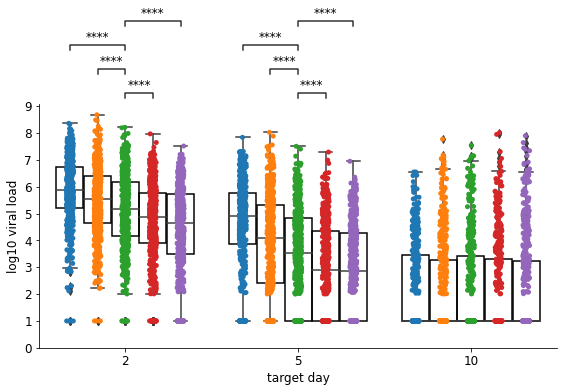

In [11]:
fig1 = plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 12})
ax = sns.stripplot(x='target day', y='log10(VL)', data = VL, hue = 'frequency', dodge=True)
handles, labels = ax.get_legend_handles_labels()
ax = sns.boxplot(x='target day', y='log10(VL)', data = VL, hue = 'frequency')
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor('black')


annotator = Annotator(ax, pair_sig, data=VL, x='target day', y='log10(VL)', hue = 'frequency')
annotator.configure(test = 'Mann-Whitney', loc='outside').apply_and_annotate()
#plt.title('Treatment starts within 3 days post symptoms\n')
#ax.legend(handles, labels, title = 'Frequency', bbox_to_anchor=(0.9, 1))
ax.get_legend().remove()
ax.set_yticks(np.linspace(0,9,10))
sns.despine()
ax.set_ylabel('log10 viral load')
#plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1), title = 'Treatment duration')

#plt.ylabel('log10(VL) drop')
    
#plt.savefig('ViralLoad_Treatmentstartday ='+ str(TreatmentStartDay)+'.svg')
plt.tight_layout()


## Fig 4c

(0.0, 40.0)

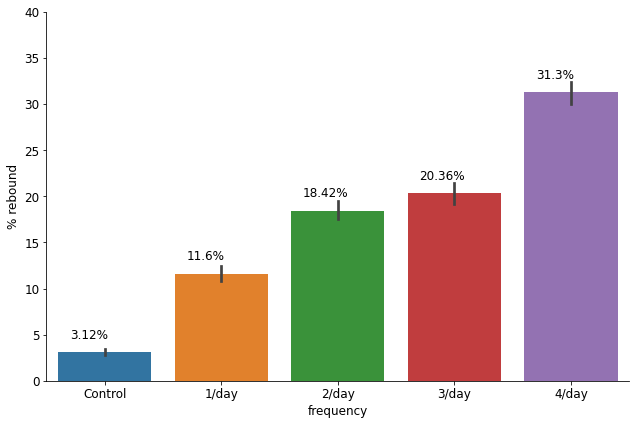

In [12]:
df_freq_1_cntrl=df_freq_1[(df_freq_1.arm=='Control')*(df_freq_1.rebound == 'Yes')]
df_freq_1_others=df_freq_1[(df_freq_1.arm!='Control')*(df_freq_1.rebound == 'Yes')]
df_freq_1_Yes = pd.concat([df_freq_1_cntrl,df_freq_1_others])
rebound_freq_Control = df_freq_1_Yes[(df_freq_1_Yes.arm=='Control')*(df_freq_1_Yes.frequency == '1/day')]
rebound_freq_Control.frequency = 'Control'
rebound_freq_1 = pd.concat([rebound_freq_Control, df_freq_1_others])
g = sns.catplot(x='frequency',y='% rebound', kind='bar',data=rebound_freq_1, height=6, aspect=1.5, ci = 95)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.1
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt, size = 'medium')

g.ax.set_ylim([0, 40])


## Fig 4b

4 examples of viral load for different frequencies shown in the paper.

In [ ]:
dose = 0
VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                               RandVLParams, parameters_df, Popparameters_df, 
                                               fixed_params, param_order, param_dist, PKPDParams, 
                                               Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                               Emax, IC50, Hill,PDOm, dose)

for idi in range(0,Num):
    if (np.log10(param_dict[idi]['V0'])>2):
       # print(np.log10(param_dict[idi]['V0']))
        param_dict1={'V0': 100}
        param_dict[idi].update(param_dict1)

V_all_freq = []
t_all_freq = []
TrtmntStrtDay_all_freq=[]
# --------------------------simulate without treament---------------------------------
TrtmntStrtDay = [random.randint(1, 3) for i in range(0,len(Cohort))]
dose = 0
X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                               PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 1)
V_all_freq.append(X)
t_all_freq.append(times)
TrtmntStrtDay_all_freq.append(TrtmntStrtDay)
# ----------------------simulate with treatment lasting for 5, 10, 15 days------------------------
for tfreq, dose in zip([1, 0.5, 0.3333, 0.25], [600, 300, 200, 150]): 

    X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                   PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                   TreatmentLength = 5, TreatmentFrequency = tfreq)
    V_all_freq.append(X)
    t_all_freq.append(times)
    TrtmntStrtDay_all_freq.append(TrtmntStrtDay)

In [ ]:
# plot a few examples
freq = ['Control', '1/day', '2/day', '3/day','4/day']
fig = plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size':15})
for i in range(0,4):
    fig.add_subplot(221+i)
    plt.vlines(x = 0, ymin = 0, ymax = 9,color = 'k')
    
    
   # plt.fill_betweenx(np.linspace(0,9,20), 1*np.ones(20), 5*np.ones(20), color = 'tab:red', alpha = 0.2)
   # plt.fill_betweenx(np.linspace(0,9,20), 5*np.ones(20), 10*np.ones(20), color = 'tab:purple', alpha = 0.2)

    
    plt.fill_between(np.linspace(-4,14,20), 0*np.ones(20), np.ones(20), color = 'grey', alpha = 0.2)
    plt.ylim(0,9)
    plt.yticks(range(0,9, 2))
    plt.xticks(range(-4,25, 4))
   # plt.xlabel('days since treatment')
  #  plt.ylabel('log10 viral load')

    for times, X, label in zip(t_all_freq,V_all_freq, freq):
        plt.plot(times[i+44],X[i+44], label = label, linewidth = 2)
      #  plt.fill_betweenx(np.linspace(0,9,20), t_all[1][j][0]*np.ones(20), (t_all[1][j][0]+1)*np.ones(20), color = 'tab:orange', alpha = 0.1)
    plt.xlim(-5,14)
plt.tight_layout()
#plt.legend(loc = 'upper left', bbox_to_anchor=(1., 1.5)) 
